In [58]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

In [413]:
import matplotlib.dates as mdates

In [418]:
bond_return_index = dl.pull('BondRetIdx/LocalFX').resample('M').mean()
bond_return_change = bond_return_index.pct_change()

def evaluate_performance(indicator, country):
    first_date = max(indicator.first_valid_index(), bond_return_index[country].first_valid_index())
    shifted_indicator = indicator.shift(1)
#     shifted_bond_return = bond_return_change.shift(-1)
    days_profit = bond_return_change[country] * shifted_indicator
    days_profit += 1
    days_profit[first_date] = bond_return_index[country][first_date]
    pnl = days_profit.cumprod()
    return pnl
    
    
def plot_evaluation(indicator, pnl, country, plot_indicator = True):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(pnl.to_timestamp(), label = 'Portfolio Returns')
    ax1.plot(bond_return_index[country].to_timestamp(), label = 'Bond Market Index')
    ax1.set_ylabel('Returns')
    ax1.legend()
    if plot_indicator:
        ax2.plot(indicator.to_timestamp(), color = 'tab:red',label = 'Indicator', alpha = 0.5)
        ax2.set_ylabel('Indicator')
        ax2.set_ylim(-1.1,1.1)
        ax2.legend(loc = 'lower right')
    plt.title(country + ' portfolio performance Index vs bond market index')
    plt.show()
    
    
    std_portfolio_pct_change = pnl.pct_change().std()
    std_market_pct_change = bond_return_index[country].resample('M').mean().pct_change().std()
    vol_adjusted_pnl = pnl * std_market_pct_change / std_portfolio_pct_change
    vol_adj_pct_chg = vol_adjusted_pnl.pct_change()
    vol_adj_pct_chg += 1
    first_date = max(vol_adj_pct_chg.first_valid_index(), bond_return_index[country].first_valid_index())
    vol_adj_pct_chg[first_date] = bond_return_index[country][first_date]
    vol_adjust_pnl_start_same_place = vol_adj_pct_chg.cumprod()
    
    
    vol_adjust_pnl_start_same_place.plot(label = 'vol adjusted portfolio returns')
    bond_return_index[country].plot(label = 'bond market returns')
    plt.legend()
    plt.ylabel('returns')
    plt.xlabel('date')
    plt.title(country + ' bond market returns index vs vol adjusted portfolio returns index')
    plt.show()

    

# Curve Height

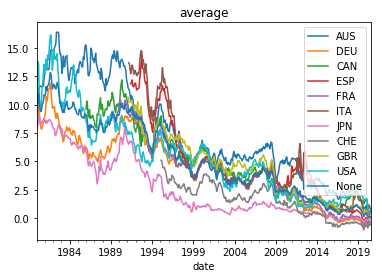

In [34]:
curve_height_indicator = pd.Series([])
short_rates = dl.pull('LongRates')
long_rates = dl.pull('ShortRates')
average_long_and_short = (long_rates + short_rates) / 2
world_average = average_long_and_short.mean(axis = 1)

average_long_and_short.plot()
world_average.plot()
plt.legend()
plt.title('average')
plt.show()

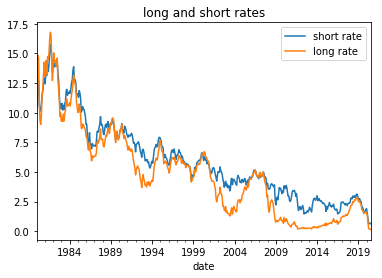

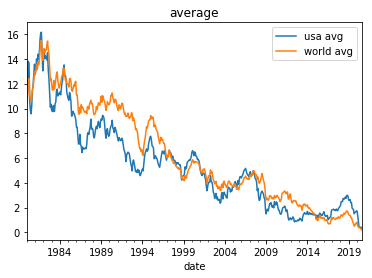

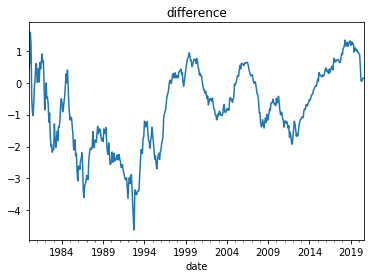

In [460]:
'''
looking at the rates and the differences
'''

curve_height_indicator = pd.Series([])
short_rates = dl.pull('LongRates')
long_rates = dl.pull('ShortRates')
average_long_and_short = (long_rates + short_rates) / 2
average_long_and_short = average_long_and_short.drop(['JPN', 'CHE', 'DEU'], axis=1)
world_average = average_long_and_short.mean(axis = 1)

short_rates['USA'].plot()
long_rates['USA'].plot()
plt.title('long and short rates')
plt.legend(['short rate', 'long rate'])
plt.show()

average_long_and_short['USA'].plot()
world_average.plot()
plt.legend(['usa avg', 'world avg'])
plt.title('average')
plt.show()

diff_usa_vs_world_avg = average_long_and_short['USA'] - world_average
diff_usa_vs_world_avg.plot()
plt.title('difference')
plt.show()

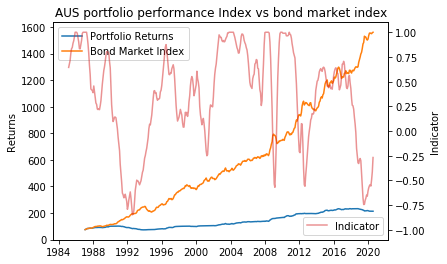

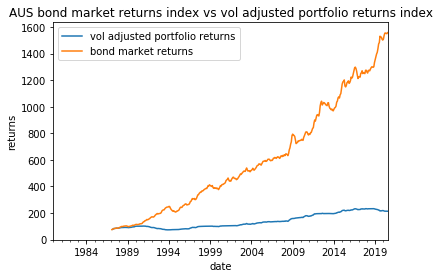

indicator std:  0.5034700227595393
indicator mean:  0.3559954470503061
min:  72.61753722981982
min index:  1994-01
max:  232.694079880835
max index:  2018-10
----------------------------------


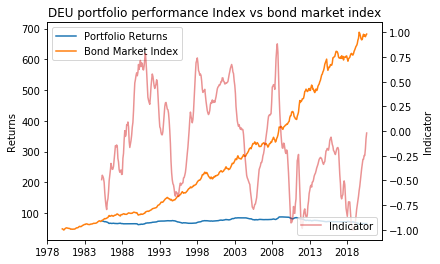

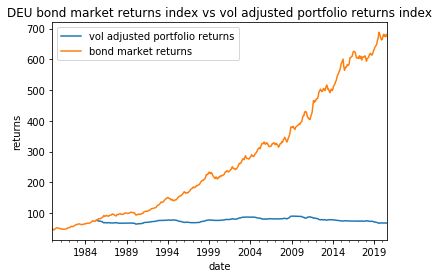

indicator std:  0.4769307618404161
indicator mean:  -0.11892782440535621
min:  62.40663958375191
min index:  1990-03
max:  87.6182201966419
max index:  2009-06
----------------------------------


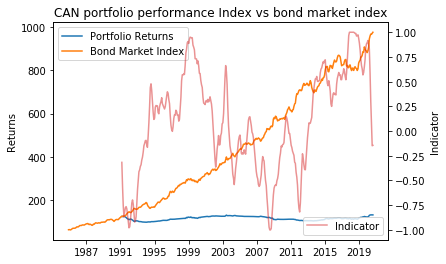

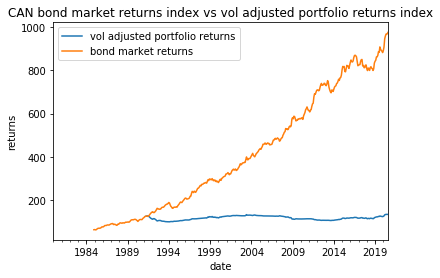

indicator std:  0.5147914230979485
indicator mean:  0.09841296348159263
min:  99.92655213846346
min index:  1994-01
max:  133.6939239797612
max index:  2020-07
----------------------------------


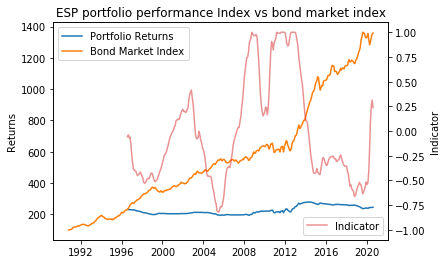

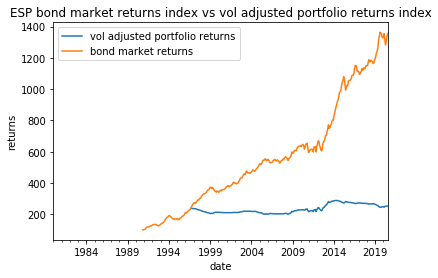

indicator std:  0.526372919961418
indicator mean:  -0.016465026750527852
min:  192.71162680380903
min index:  2005-09
max:  278.5525573669086
max index:  2014-05
----------------------------------


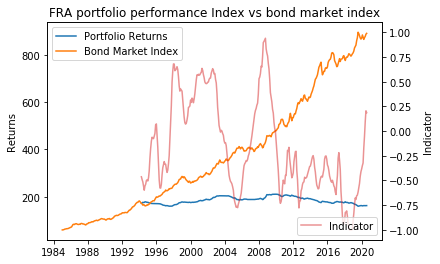

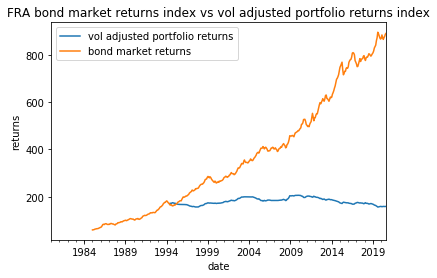

indicator std:  0.47541723899196625
indicator mean:  -0.15569283224585068
min:  159.6505939586889
min index:  2019-08
max:  210.63570649774186
max index:  2010-01
----------------------------------


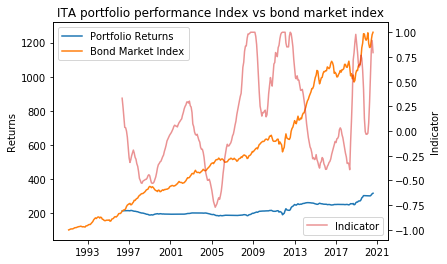

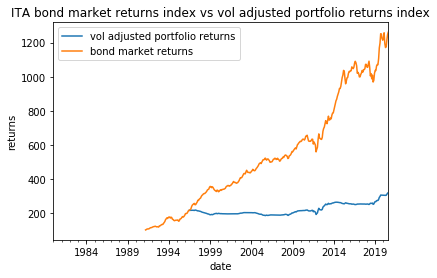

indicator std:  0.48237638983513037
indicator mean:  0.08703349409558367
min:  182.07721689338368
min index:  2005-09
max:  315.528328260275
max index:  2020-08
----------------------------------


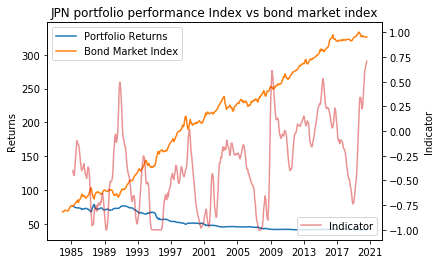

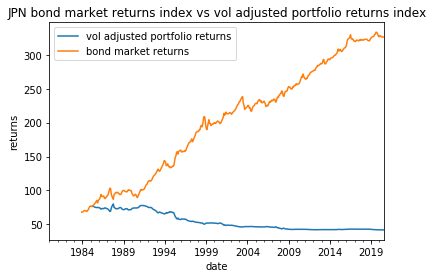

indicator std:  0.4047745700789979
indicator mean:  -0.3513762881107697
min:  41.061143687579374
min index:  2020-06
max:  78.71539795262856
max index:  1987-10
----------------------------------


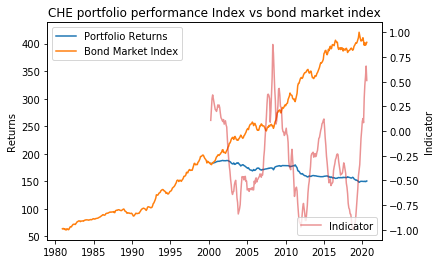

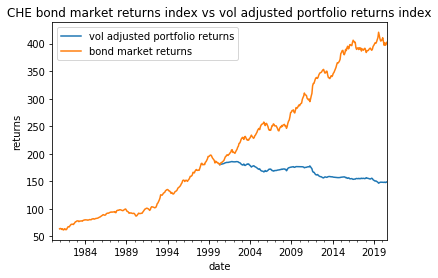

indicator std:  0.4003346452876977
indicator mean:  -0.2776241289527089
min:  148.20606225013603
min index:  2019-08
max:  187.88691069507925
max index:  2001-11
----------------------------------


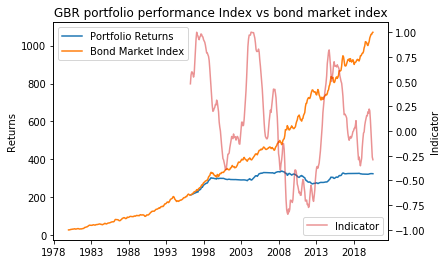

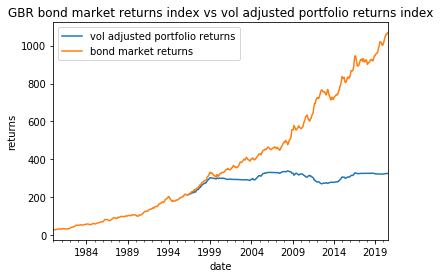

indicator std:  0.5093263602791512
indicator mean:  0.11263004460469904
min:  211.6734545454545
min index:  1996-04
max:  338.0639137357338
max index:  2008-06
----------------------------------


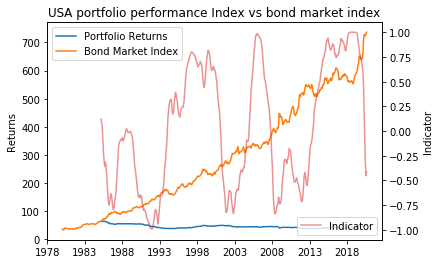

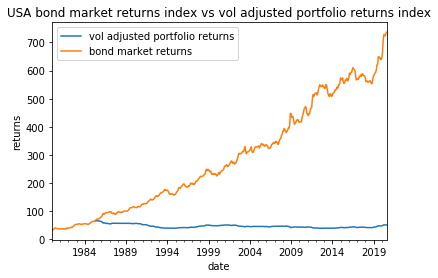

indicator std:  0.6222428467934515
indicator mean:  0.043803529043244784
min:  38.12855237903847
min index:  2012-07
max:  64.03719198594193
max index:  1985-07
----------------------------------


In [419]:
'''
calcualting and plotting the equal weighted z-score indicator
'''

countries = bond_return_index.columns

for country in countries:
    std_curve_height_indicator = pd.Series([])
    short_rates = dl.pull('LongRates')
    long_rates = dl.pull('ShortRates')
    average_long_and_short = (long_rates + short_rates) / 2
    world_average = average_long_and_short.mean(axis = 1)
    diff_vs_world_avg = (average_long_and_short[country] - world_average)
    avg_diff = diff_vs_world_avg.rolling(5*12).mean()
    std_dev_world = average_long_and_short.std(axis = 1)
    std_country_past_year = diff_vs_world_avg.rolling(5*12).std()

    z_score_world = diff_vs_world_avg / std_dev_world
    z_score_country = (diff_vs_world_avg - avg_diff) / std_country_past_year

    std_curve_height_indicator = ((z_score_world + z_score_country) / 2)
    std_curve_height_indicator = std_curve_height_indicator/1.5
    std_curve_height_indicator = std_curve_height_indicator.clip(-1,1)

    std_pnl = evaluate_performance(std_curve_height_indicator, country)
    plot_evaluation(std_curve_height_indicator, std_pnl, country, plot_indicator = True)
    print('indicator std: ', std_curve_height_indicator.std())
    print('indicator mean: ', std_curve_height_indicator.mean())
    print('min: ', std_pnl.min())
    print('min index: ', std_pnl.idxmin())
    print('max: ', std_pnl.max())
    print('max index: ', std_pnl.idxmax())
    print('----------------------------------')

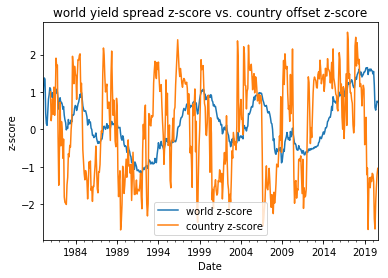

In [171]:
'''
plot both z-scores to see what is happening over time
'''

# z_score_world, z_score_country
z_score_world.plot(label = 'world z-score')
z_score_country.plot(label = 'country z-score')
plt.title('world yield spread z-score vs. country offset z-score')
plt.legend()
plt.ylabel('z-score')
plt.xlabel('Date')
plt.show()

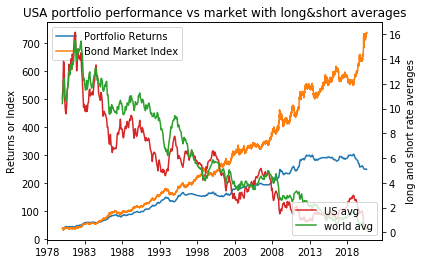

In [111]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(std_pnl.to_timestamp(), label = 'Portfolio Returns')
ax1.plot(bond_return_index['USA'].to_timestamp(), label = 'Bond Market Index')
ax1.set_ylabel('Returns or Index')
ax1.legend()
ax2.plot(average_long_and_short['USA'].to_timestamp(), color = 'tab:red',label = 'US avg')
ax2.plot(world_average.to_timestamp(), color = 'tab:green',label = 'world avg')
ax2.set_ylabel('long and short rate averages')
ax2.legend(loc = 'lower right')
plt.title('USA portfolio performance vs market with long&short averages')
plt.show()

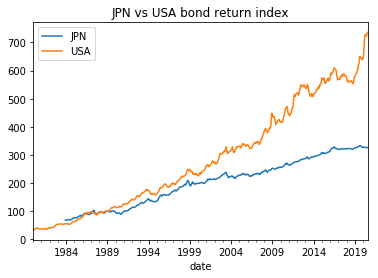

In [226]:
bond_return_index['JPN'].plot(label = 'JPN')
bond_return_index['USA'].plot(label = 'USA')
plt.legend()
plt.title('JPN vs USA bond return index')
plt.show()


 AUS


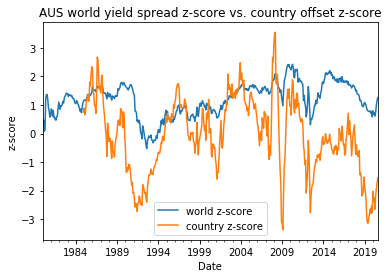

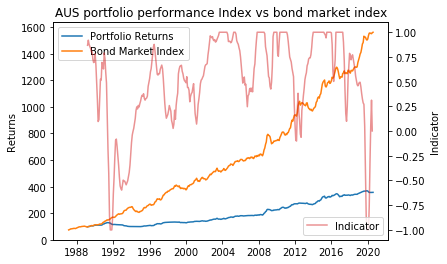

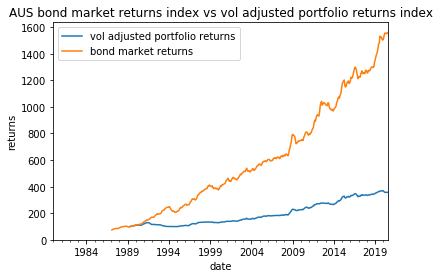

----------------------------------

 DEU


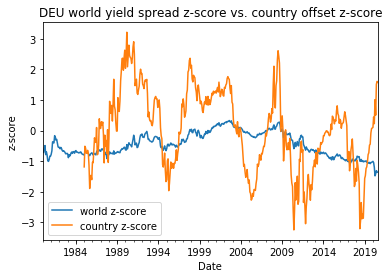

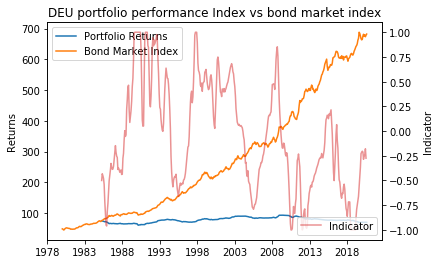

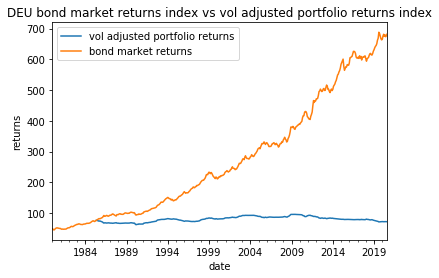

----------------------------------

 CAN


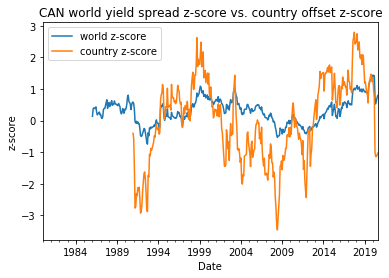

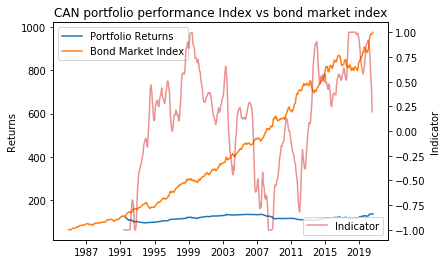

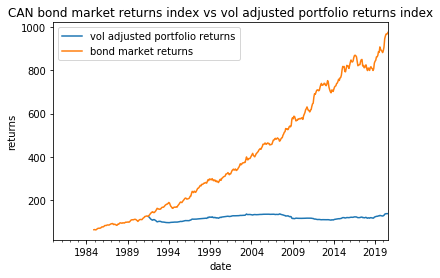

----------------------------------

 ESP


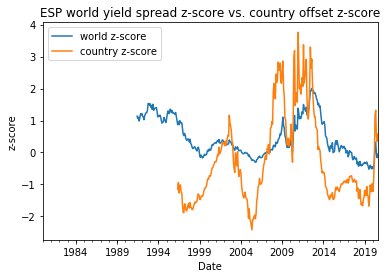

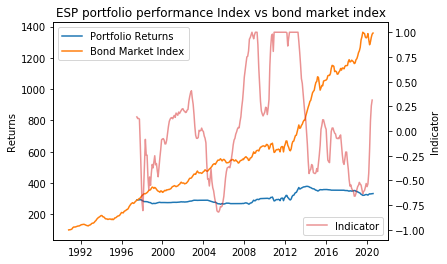

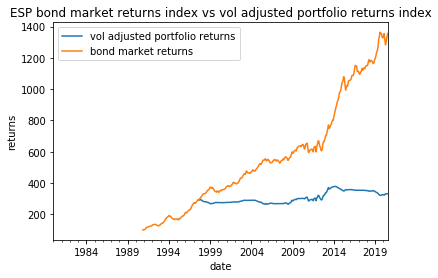

----------------------------------

 FRA


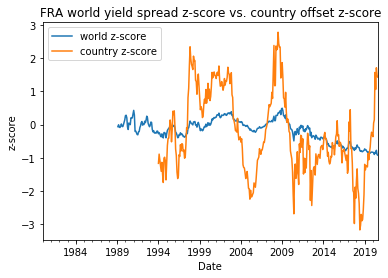

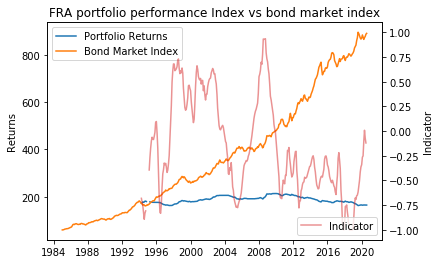

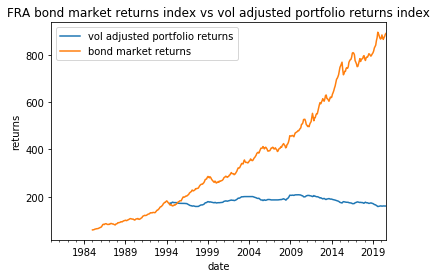

----------------------------------

 ITA


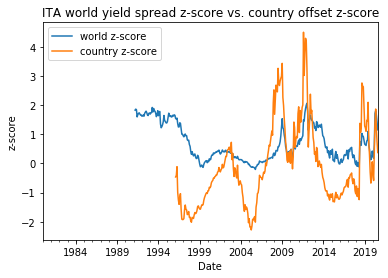

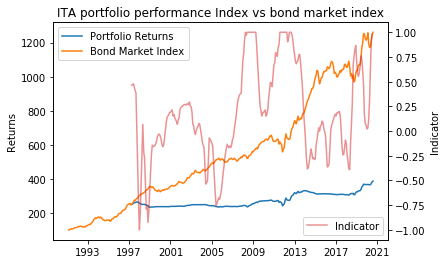

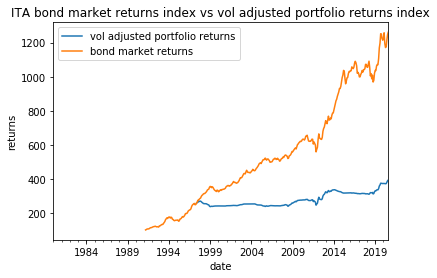

----------------------------------

 JPN


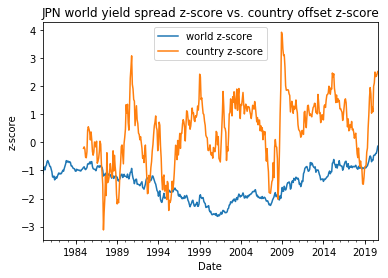

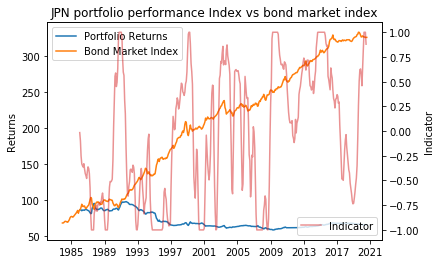

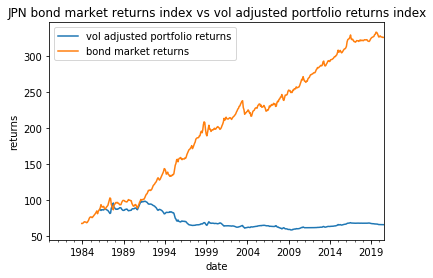

----------------------------------

 CHE


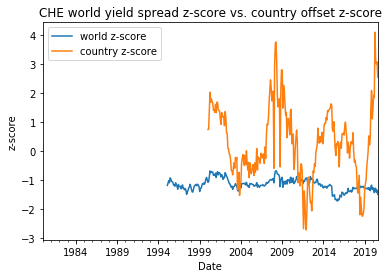

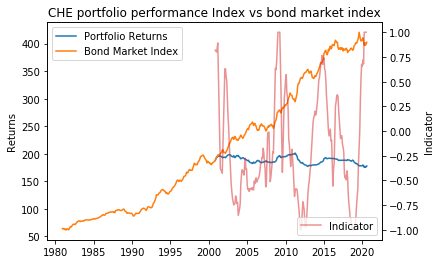

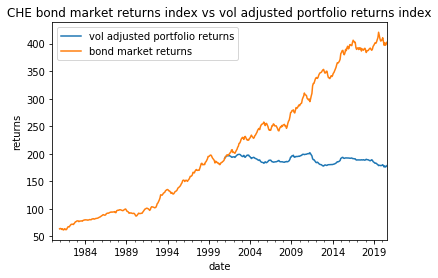

----------------------------------

 GBR


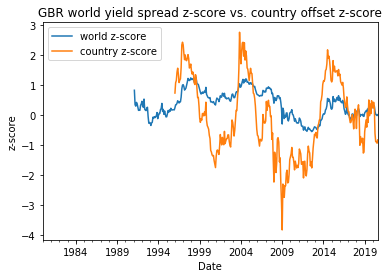

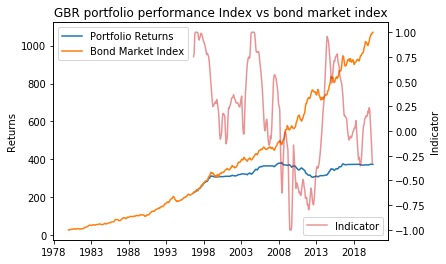

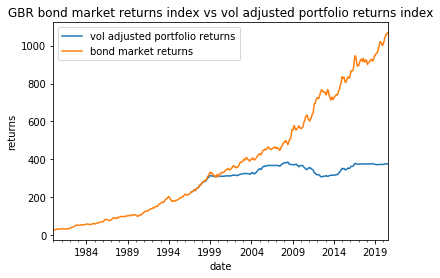

----------------------------------

 USA


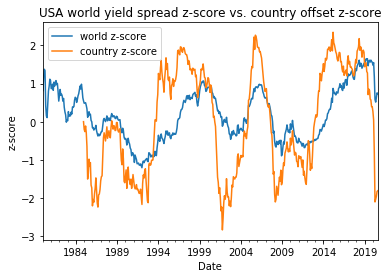

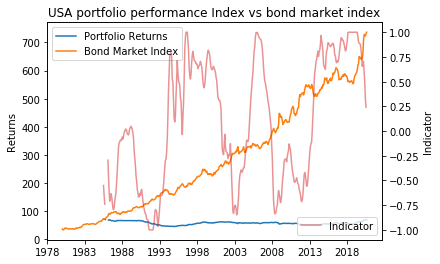

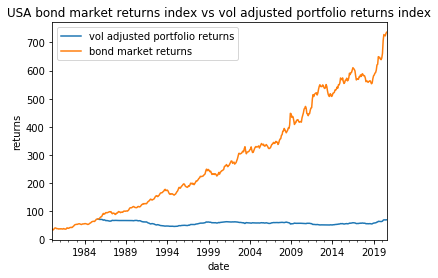

----------------------------------


In [454]:
'''
calcualting and plotting the correlation weighted z-score indicator
correlation is over the past 12 months
z-score from past 5 years
since the correlaiton should be positive, I only wanted to weight the z-score if it had a positive correlation
If both correlations were negative, I set both weights to 0.5
if one was positive and one was negative, I set the positive one to 0.9 and the negative one to 0.1 (I figure 
weight the one that is predicting movement in the directioni we expected the highest, but still count the other one)
If both were positive, then just weight them by the magnitude of their correlation
'''

countries = bond_return_index.columns

for country in countries:
    print('\n', country)
    std_curve_height_indicator = pd.Series([])
    short_rates = dl.pull('LongRates')
    long_rates = dl.pull('ShortRates')
    average_long_and_short = (long_rates + short_rates) / 2
    world_average = average_long_and_short.mean(axis = 1)
    diff_vs_world_avg = (average_long_and_short[country] - world_average)
    avg_diff = diff_vs_world_avg.rolling(5*12).mean()
    std_dev_world = average_long_and_short.std(axis = 1)
    std_country_past_year = diff_vs_world_avg.rolling(5*12).std()

    z_score_world = diff_vs_world_avg / std_dev_world
    z_score_world_returns = z_score_world * bond_return_change[country].shift(-1)
    world_corr = z_score_world_returns.rolling(12).corr(bond_return_change[country].shift(-1).rolling(12).mean())
    
    z_score_country = (diff_vs_world_avg - avg_diff) / std_country_past_year
    z_score_country_returns = z_score_country * bond_return_change[country].shift(-1)
    country_corr = z_score_country_returns.rolling(12).corr(bond_return_change[country].shift(-1).rolling(12).mean())

    country_weight = pd.Series([])
    world_weight = pd.Series([])
    for date in country_corr.index:
        if country_corr[date] < 0:
            if world_corr[date] < 0:
                country_weight.loc[date] = 0.5
                world_weight.loc[date] = 0.5
            else:
                country_weight.loc[date] = 0.1
                world_weight.loc[date] = 0.9
        elif world_corr[date] < 0:
            country_weight.loc[date] = 0.9
            world_weight.loc[date] = 0.1
        else:
            country_weight.loc[date] = country_corr[date] / (country_corr[date] + world_corr[date])
            world_weight.loc[date] = world_corr[date] / (country_corr[date] + world_corr[date])

    z_score_world.plot(label = 'world z-score')
    z_score_country.plot(label = 'country z-score')
    plt.title(country + ' world yield spread z-score vs. country offset z-score')
    plt.legend()
    plt.ylabel('z-score')
    plt.xlabel('Date')
    plt.show()
    std_curve_height_indicator = z_score_world * world_weight + z_score_country * country_weight
    std_curve_height_indicator = std_curve_height_indicator/1.5

    std_curve_height_indicator = std_curve_height_indicator.clip(-1,1)

    std_pnl = evaluate_performance(std_curve_height_indicator, country)
    plot_evaluation(std_curve_height_indicator, std_pnl, country, plot_indicator = True)
    print('----------------------------------')

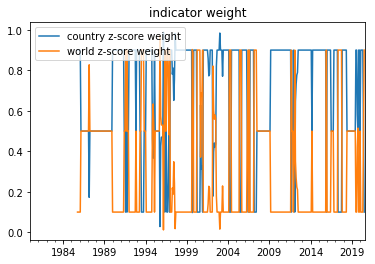

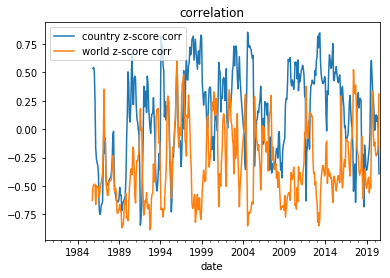

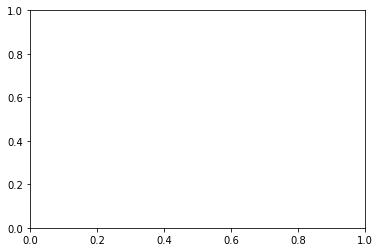

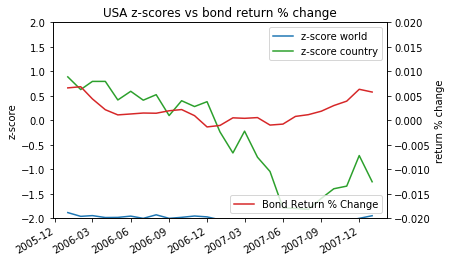

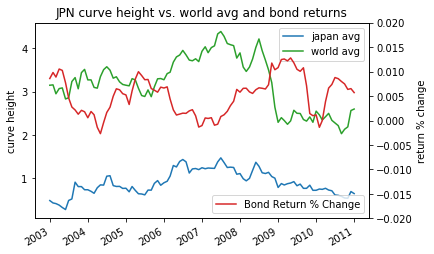

In [452]:
'''
Building some other charts to see the correlation weightings, the z-scores, and the bond returns
to better understand what is actually going on in the charts and see if what we are expecting to 
happen actually happened

zooming in on certain windows to make it easier to view trends
'''
temp = bond_return_change['GBR'].shift(-1).rolling(12).mean()
mask = (z_score_world.index >= '2006') & (z_score_world.index <= '2008')
mask2 = (z_score_country.index >= '2006') & (z_score_country.index <= '2008')
mask3 = (temp.index >= '2006') & (temp.index <= '2008')
mask4 = (country_weight.index >= '2006') & (country_weight.index <= '2008')
mask5 = (world_weight.index >= '2006') & (world_weight.index <= '2008')
# .loc[mask2]
country_weight.plot(label = 'country z-score weight')
world_weight.plot(label = 'world z-score weight')
plt.legend()
plt.title('indicator weight')
plt.show()
country_corr.plot(label = 'country z-score corr')
world_corr.plot(label = 'world z-score corr')
plt.legend()
plt.title('correlation')
plt.show()
# bond_return_change[country].shift(-1).plot(label = 'return change')
# z_score_world
# z_score_country
plt.legend()
plt.show()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(z_score_world.loc[mask].to_timestamp(), label = 'z-score world')
ax1.plot(z_score_country.loc[mask2].to_timestamp(), color = 'tab:green', label = 'z-score country')
ax1.set_ylabel('z-score')
ax1.legend(loc = 'upper right')
ax1.set_ylim(-2,2)
ax2.plot(temp.loc[mask3].to_timestamp(), color = 'tab:red',label = 'Bond Return % Change')
ax2.set_ylabel('return % change')
ax2.legend(loc = 'lower right') #loc = 'lower right'
ax2.set_ylim(-0.02,0.02)
fig.autofmt_xdate()
plt.title('USA' + ' z-scores vs bond return % change')
plt.show()


mask6 = (average_long_and_short['JPN'].index >= '2003') & (average_long_and_short['JPN'].index <= '2011')
mask7 = (world_average.index >= '2003') & (world_average.index <= '2011')
mask8 = (temp.index >= '2003') & (average_long_and_short.index <= '2011')
# average_long_and_short['JPN'].loc[mask6].plot()
# world_average.loc[mask7].plot(label = 'World Avg')
# plt.title('Curve Heights of World Bonds')
# plt.legend()
# plt.ylabel('Yield Curve Height')
# plt.xlabel('Date')
# plt.show()


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(average_long_and_short['JPN'].loc[mask6].to_timestamp(), label = 'japan avg')
ax1.plot(world_average.loc[mask7].to_timestamp(), color = 'tab:green', label = 'world avg')
ax1.set_ylabel('curve height')
ax1.legend(loc = 'upper right')
# ax1.set_ylim(-2,2)
ax2.plot(temp.loc[mask8].to_timestamp(), color = 'tab:red',label = 'Bond Return % Change')
ax2.set_ylabel('return % change')
ax2.legend(loc = 'lower right') #loc = 'lower right'
ax2.set_ylim(-0.02,0.02)
fig.autofmt_xdate()
plt.title('JPN' + ' curve height vs. world avg and bond returns')
plt.show()


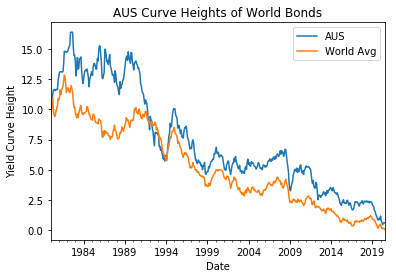

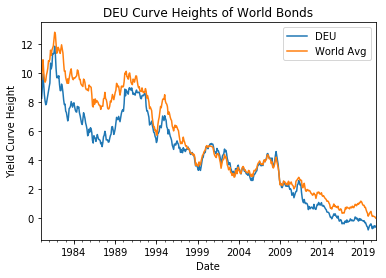

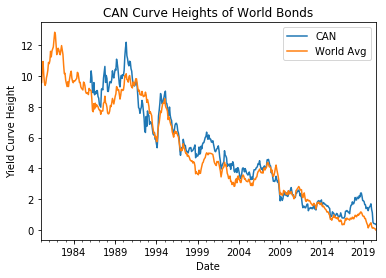

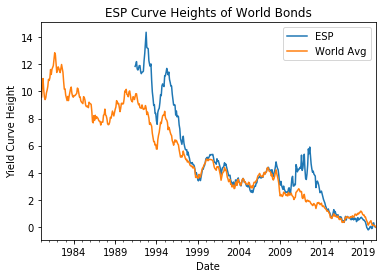

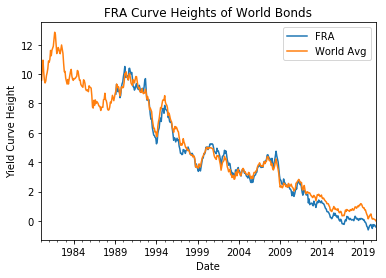

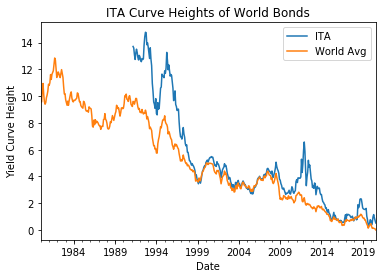

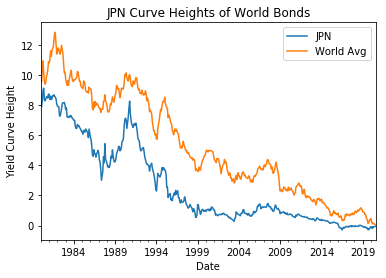

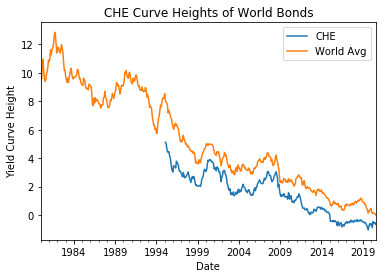

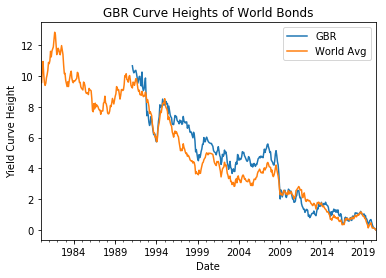

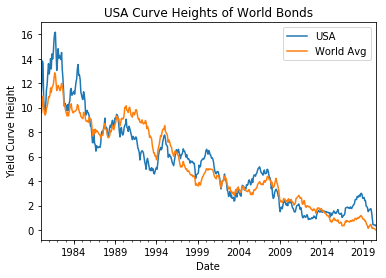

In [335]:
'''
plotting other useful graphs (world curve height vs average)
'''

countries = bond_return_index.columns

for country in countries:
    average_long_and_short[country].plot()
    world_average.plot(label = 'World Avg')
    plt.title(country + ' Curve Heights of World Bonds')
    plt.legend()
    plt.ylabel('Yield Curve Height')
    plt.xlabel('Date')
    plt.show()
    
    